In [1]:
#@ IMPORTING THE LIBRARIES AND DEPENDENCIES: 
# !pip install -U d2l
%matplotlib inline 
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
#@ INITIALIZING MODEL PARAMETERS: 
scale = 0.01                                                      # Initialization. 
W1 = torch.randn(size=(20, 1, 3, 3)) * scale                      # Initializing the Parameter. 
b1 = torch.zeros(20)                                              # Initializing the Tensor of zeros. 
W2 = torch.randn(size=(50, 20, 5, 5)) * scale                     # Initializing the Parameter. 
b2 = torch.zeros(50)                                              # Initializing the Tensor of zeros. 
W3 = torch.randn(size=(800, 128)) * scale                         # Initializing the Parameter. 
b3 = torch.zeros(128)                                             # Initializing the Tensor of zeros. 
W4 = torch.randn(size=(128, 10)) * scale                          # Initializing the Parameter. 
b4 = torch.zeros(10)                                              # Initializing the Tensor of zeros. 
params = [W1, b1, W2, b2, W3, b3, W4, b4]                         # Initializing a list of Parameters. 

In [3]:
#@ DEFINING THE LENET MODEL: 
def lenet(X, params):                                                         # Initializing the LENET Model. 
  h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])               # Initializing the Convolutional Layer. 
  h1_activation = F.relu(h1_conv)                                             # Initializing the RELU Activation Function. 
  h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))   # Initializing the Average Pooling Layer. 
  h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])              # Initializing the Convolutional Layer. 
  h2_activation = F.relu(h2_conv)                                             # Initializing the RELU Activation Function. 
  h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))   # Initializing the Average Pooling Layer. 
  h2 = h2.reshape(h2.shape[0], -1)                                            # Changing the shape. 
  h3_linear = torch.mm(h2, params[4] + params[5])                             # Initializing the Matrix Multiplication. 
  h3 = F.relu(h3_linear)                                                      # Initializing the RELU Activation Function. 
  y_hat = torch.mm(h3, params[6] + params[7])                                 # Initializing the Matrix Multiplication. 
  return y_hat
#@ INITIALIZING CROSSENTROPY LOSS FUNCTION: 
loss = nn.CrossEntropyLoss(reduction="none")                                  # Initializing the Cross Entropy Loss Function. 

In [4]:
#@ IMPLEMENTATION OF DATA SYNCHRONIZATION: 
def get_params(params, device):                                               # Initializing the Parameters.           
  new_params = [p.clone().to(device) for p in params]
  for p in new_params: 
    p.requires_grad_()
  return new_params
#@ IMPLEMENTATION DATA SYNCHRONIZATION: 
def allreduce(data):                                                          # Getting sum of the results. 
  for i in range(1, len(data)):
    data[0][:] += data[i].to(data[0].device)
  for i in range(1, len(data)):
    data[i] = data[0].to(data[i].device)
#@ IMPLEMENTATION OF DATA DISTRIBUTION: 
def split_data(X, y, devices):                                                # Data Distribution. 
  assert X.shape[0] == y.shape[0]
  return (nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices))

Test acc: 0.10, 6.8 sec/epochon [device(type='cuda', index=0)]


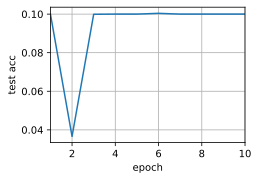

In [5]:
#@ IMPLEMENTATION OF TRAINING FUNCTION: 
def train_batch(X, y, device_params, devices, lr):                                  # Function for Training Batches. 
  X_shards, y_shards = split_data(X, y, devices)                                    # Initializing the Data Distribution Function. 
  losses = [loss(lenet(X_shard, device_W), y_shard).sum() for 
            X_shard, y_shard, device_W in zip(X_shards, y_shards, device_params)] 
  for l in losses: 
    l.backward()                                                                    # Initializing Back Propagation. 
  with torch.no_grad():
    for i in range(len(device_params[0])):
      allreduce([device_params[c][i].grad for c in range(len(devices))])
  for param in device_params: 
    d2l.sgd(param, lr, X.shape[0])
#@ IMPLEMENTATION OF TRAINING FUNCTION: 
def train(num_gpus, batch_size, lr):                                                # Function for Training the Model. 
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)                   # Initializing the Training and Test Iterations. 
  devices = [d2l.try_gpu(i) for i in range(num_gpus)]
  device_params = [get_params(params, d) for d in devices]                          # Initializing the Model Parameters. 
  num_epochs = 10                                                                   # Initializing the Training Epochs. 
  animator = d2l.Animator("epoch", "test acc", xlim=[1, num_epochs])                # Initializing the Animation.
  timer = d2l.Timer()                                                               # Initializing the Timer. 
  for epoch in range(num_epochs):
    timer.start()
    for X, y in train_iter: 
      train_batch(X, y, device_params, devices, lr)
      torch.cuda.synchronize()
    timer.stop()
    animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
        lambda x: lenet(x, device_params[0]), test_iter, devices[0]), ))
  print(f"Test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch"
        f"on {str(devices)}")
#@ EXPERIMENTATION:
train(num_gpus=1, batch_size=256, lr=0.2)                                             # Training the Model. 